# PLOT FOR THR, LATENCY FOR POWER MODE TESTs

#### Globals and Imports

In [51]:
PLATFORM="Orin AGX"

#POWER_MODES={'PM0': {},'PM1': {},'PM2': {}} #{'PM0': {},'PM1': {},'PM2': {}}   
POWER_MODES={'LVL5': {},'LVL3': {},'LVL0': {}} 
#POWER_MODES={'DYNAMIC': {},'STATIC': {}} 

#PATH_TO_MD="../outputs/table_outputs/evaluaciones_adicionales/orin_agx/jetson_orin_agx_power_mode_test.md"
PATH_TO_MD="../outputs/table_outputs/evaluaciones_adicionales/orin_agx/jetson_orin_agx_optimization_level_test.md"
#PATH_TO_MD="../outputs/table_outputs/evaluaciones_adicionales/orin_agx/jetson_orin_agx_static_vs_dynamic_test.md"

In [52]:
import re
import matplotlib.pyplot as plt
import numpy as np

### FUNCTIONS

In [53]:
def parse_markdown_data_for_throughput(file_content):

    # la idea de esta funcion es agrupar el throupgut y la confianza en data_summary para cada plataforma, para poder luego hacer el print del grafico de los througputs
    power_mode_datas = file_content.split(f'# {PLATFORM} ')[1:]  # Divide por power mode
    data_summary = {}

    # Procesar datos principales para batch size 1 y añadir inf/s de batch size 256 cuando corresponda
    for power_mode_data in power_mode_datas:
        power_mode_saved = power_mode_data.splitlines()[0].strip()
        models_data = power_mode_data.split('## ')[1:]  # Divide por modelo y batch size, ignorando el primer split que estaría vacío
        for model_section in models_data:
            lines = model_section.split('\n')
            model_name_batch_size = lines[0].strip()
            model_name, batch_size_info = model_name_batch_size.split(' bs ')
            batch_size = int(batch_size_info.strip())

            table_data = [line for line in lines if '|' in line and 'Model' not in line]

            for data in table_data:
                if not all(char == '-' for char in data.replace('|', '').strip()):
                    cols = [col.strip() for col in data.split('|')]
                    if len(cols) > 1:
                        model_variant = cols[1]
                        inf_s_str = (cols[2].split(' ')[0].replace('.','')).replace(',','.')
                        inf_s = float(inf_s_str)
                        confianza_str_minus = (cols[2].split(' ')[3].replace('.','')).replace(',','.').replace('-','')
                        confianza_str_plus = (cols[2].split(' ')[2].replace('.','')).replace(',','.').replace('+','')
                        confianza = max(float(confianza_str_minus),float(confianza_str_plus))
                        
                        if power_mode_saved not in data_summary:
                            data_summary[power_mode_saved] = {}
                        if model_name not in data_summary[power_mode_saved]:
                            data_summary[power_mode_saved][model_name] = {}
                        if model_variant not in data_summary[power_mode_saved][model_name]:
                            data_summary[power_mode_saved][model_name][model_variant] = {}
                        data_summary[power_mode_saved][model_name][model_variant][batch_size] = inf_s, confianza

    return data_summary

In [54]:
# Función para graficar los datos de throughput (thr)
def plot_thr(data):
    # Recorrer cada red neuronal
    for network, optimizations in list(data.values())[0].items():
        # Recorrer cada optimización
        for optimization in optimizations.keys():
            plt.rcParams.update({'font.size': 14})  # Ajustar el tamaño de la fuente
            plt.figure(figsize=(5, 3.5)).tight_layout()

            # Graficar los resultados para cada modo de potencia
            for power_mode, networks in data.items():
                if network not in networks:
                    continue  # Saltar si la red no está en este modo de potencia

                optim_data = networks[network][optimization]  # Datos de la optimización específica
                batch_sizes_sorted = sorted(optim_data.keys())  # Ordenar los tamaños de lote
                infs = [optim_data[bs][0] for bs in batch_sizes_sorted]  # Obtener los valores de inferencias

                # Graficar los resultados
                plt.plot(batch_sizes_sorted, infs, marker='o', label=f'{power_mode}')
            
            # Configurar los detalles del gráfico
            plt.title(f'Jetson {PLATFORM}, {network} - {optimization}')
            plt.xlabel('Batch Size')
            plt.ylabel('Throughput [inf/s]')
            plt.legend(title='Power Mode')
            plt.grid(True)
            plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')  # Ajusta la grilla principal
            plt.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgrey')  # Ajusta la grilla secundaria
            plt.minorticks_on()
            plataforma = PLATFORM.split(' ')[1]
            plt.savefig(f'Thr_{plataforma}_{network}_{optimization}.pdf', format='pdf', bbox_inches='tight')  # Guardar la figura (opcional)
            plt.show()

In [55]:
# Función para graficar los datos de throughput (thr) en una figura con múltiples subplots por "power mode"
def plot_thrs_red_by_power_mode(data):
    for network, optimizations in list(data.values())[0].items():
        plt.rcParams.update({'font.size': 14})  # Ajustar el tamaño de la fuente
        num_power_modes = len(data.keys())
        
        # Encontrar el valor máximo de throughput (thr) para esta red
        max_thr = 0
        for power_mode, networks in data.items():
            if network not in networks:
                continue
            for optimization in optimizations.keys():
                optim_data = networks[network][optimization]
                batch_sizes_sorted = sorted(optim_data.keys())
                infs = [optim_data[bs][0] for bs in batch_sizes_sorted]
                max_thr = max(max_thr, max(infs))

        # Crear subplots en una fila con un subplot por "power mode"
        fig, axes = plt.subplots(1, num_power_modes, figsize=(5 * num_power_modes, 3.5))
        fig.tight_layout()
        fig.subplots_adjust(wspace=0.05)  # Ajustar el espacio horizontal entre subplots (reducido)

        for idx, (power_mode, ax) in enumerate(zip(data.keys(), axes)):
            # Graficar los resultados para cada optimización dentro de este modo de potencia
            networks = data[power_mode]
            if network not in networks:
                continue  # Saltar si la red no está en este modo de potencia
            
            for optimization in optimizations.keys():
                optim_data = networks[network][optimization]  # Datos de la optimización específica
                batch_sizes_sorted = sorted(optim_data.keys())  # Ordenar los tamaños de lote
                infs = [optim_data[bs][0] for bs in batch_sizes_sorted]  # Obtener los valores de inferencias

                # Graficar los resultados en el subplot correspondiente
                ax.plot(batch_sizes_sorted, infs, marker='o', label=f'{optimization}')
            
            # Configurar los detalles del subplot
            ax.set_title(f'{power_mode} - {network}')
            ax.set_xlabel('Batch Size')
            
            # Establecer el límite superior del eje Y al máximo valor de throughput
            ax.set_ylim(0, max_thr+10)
            ax.set_xlim(0, 270)
            # Solo el primer subplot tiene el label del eje Y
            if idx == 0:
                ax.set_ylabel('Throughput [inf/s]')
                ax.legend(title='Optimization')  # Leyenda solo en el primer gráfico
            else:
                ax.set_ylabel('')  # No mostrar el label del eje Y
                ax.tick_params(labelleft=False)  # No mostrar los valores del eje Y
                if ax.get_legend() is not None:  # Verificar si la leyenda existe antes de eliminarla
                    ax.get_legend().remove()

            ax.grid(True)
            ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey')  # Ajusta la grilla principal
            ax.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgrey')  # Ajusta la grilla secundaria
            ax.minorticks_on()

        plataforma = PLATFORM.split(' ')[1]
        #plt.suptitle(f'Jetson {PLATFORM}, {network}')  # Título general de la figura
        plt.savefig(f'Thr_{plataforma}_{network}.pdf', format='pdf', bbox_inches='tight')  # Guardar la figura (opcional)
        plt.show()

In [56]:
# Función para leer los datos del archivo .md considerando solo batch size 1
def read_data_from_md_for_latency(file_path):
    data = {}
    current_pm = None
    current_network = None
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
        for line in lines:
            # Detectar el Power Mode
            if line.startswith(f'# {PLATFORM}'):
                current_pm = line.strip().split()[-1]
                if current_pm not in POWER_MODES:
                    POWER_MODES[current_pm] = {}  # Añadir a POWER_MODES si no está presente
            
            # Detectar el nombre de la red y el batch size
            network_match = re.match(r'## (\w+) bs (\d+)', line)
            if network_match:
                current_network = network_match.group(1)
                batch_size = int(network_match.group(2))
                
                # Continuar solo si el batch size es 1
                if batch_size != 1:
                    current_network = None  # Ignorar este bloque si no es batch size 1
                    continue
            
            # Leer los datos de la tabla si el batch size es 1
            table_match = re.match(r'\| (\w+)\s+\|\s+[\d.,]+.*?\|\s+([\d.,/ ]+)', line)
            if table_match and current_pm and current_network:
                model = table_match.group(1)
                latency_str = table_match.group(2).split('/')[0].strip()
                latency_max_str =  table_match.group(2).split('/')[1].strip()
                
                # Convertir la latencia a flotante
                try:
                    latency = float(latency_str.replace(',', '.'))
                    latency_max = float(latency_max_str.replace(',', '.'))
                except ValueError:
                    print(f"Error de conversión de latencia: '{latency_str}' en el modelo '{model}'")
                    continue
                
                # Organizar los datos en el diccionario
                if model not in data:
                    data[model] = {pm: {} for pm in POWER_MODES.keys()}
                data[model][current_pm][current_network] = (latency,latency_max)
    return data


In [57]:
# Función para graficar los datos
def plot_model_latency(model_name, model_data):
    plt.rcParams.update({'font.size': 14})  # Ajustar el tamaño de la fuente
    plt.figure(figsize=(5, 3.5)).tight_layout()

    networks = list(model_data[next(iter(POWER_MODES))].keys())  # Listado de redes

    # Crear listas de latencias para cada modo de energía definido en POWER_MODES
    latencies_by_pm = {pm: [model_data[pm].get(net, 0) for net in networks] for pm in POWER_MODES.keys()}

    # Crear gráfico de barras
    bar_width = 0.25
    index = range(len(networks))

    # Desplazar las barras para cada modo de energía
    for i, (pm, latencies) in enumerate(latencies_by_pm.items()):
        plt.bar([x + i * bar_width for x in index], latencies, bar_width, label=f'Power Mode {pm}')

    plt.title(f'Jetson {PLATFORM}, {model_name}')
    plt.xlabel('Network')
    plt.ylabel('Latency (ms)')
    plt.xticks([i + (len(POWER_MODES) - 1) * bar_width / 2 for i in index], networks)
    plt.legend()
    plt.grid(True)
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')  # Ajusta la grilla principal
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgrey')  # Ajusta la grilla secundaria
    plt.minorticks_on()
    # Guardar el gráfico como PDF con el nombre del modelo
    plataforma = PLATFORM.split(' ')[1]
    plt.savefig(f'latency_{plataforma}_{model_name}.pdf', format='pdf', bbox_inches='tight')
    plt.show()

In [58]:
def plot_model_latency_by_power_mode(data):
    plt.rcParams.update({'font.size': 14})  # Ajustar el tamaño de la fuente

    # Asumiendo que todas las redes y optimizaciones están presentes en todos los modos de potencia
    sample = next(iter(data.values()))
    power_modes = list(sample.keys())  # Listado de power modes
    num_power_modes = len(power_modes)
    models = list(data.keys())  # Lista de vanilla, fp32, fp16 e int8
    networks = list(sample[next(iter(sample))].keys())  # Listado de optimizaciones
    
    # Calcular la latencia máxima para establecer los límites del eje Y
    max_latency = 0
    for model_data in data.values():
        for power_mode_data in model_data.values():
            for avg, max_ in power_mode_data.values():
                max_latency = max(max_latency, max_)
    
    # Crear subplots en una fila con un subplot por cada "power mode"
    fig, axes = plt.subplots(1, num_power_modes, figsize=(5 * num_power_modes, 3.5))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.05)  # Ajustar el espacio horizontal entre subplots

    bar_width = 0.15  # Ajuste del ancho de las barras para múltiples redes
    index = range(len(networks))  # Ahora las optimizaciones estarán en el eje X

    for i, power_mode in enumerate(power_modes):
        ax = axes[i]  # Seleccionar el subplot correcto
        for idx, model in enumerate(models):
            model_data = data[model]
            if power_mode in model_data:
                latencies_avg = [model_data[power_mode][network][0] for network in networks]  # Obtener latencia promedio por optimización
                latencies_max = [model_data[power_mode][network][1] - model_data[power_mode][network][0] for network in networks]  # Calcular error (latencia_max - latencia_avg)
                y_errors = np.array([np.zeros(len(latencies_avg)), latencies_max])
                # Graficar las barras con barras de error, usando el color de la barra para las líneas de error
                bars = ax.bar([x + idx * bar_width for x in index], latencies_avg, bar_width, yerr=y_errors, 
                              label=f'{model}', capsize=5, ecolor='black',  # `ecolor` se ajustará más adelante
                              error_kw={'elinewidth': 1.5})  # Grosor de las líneas de error

                # Ajustar el color de las barras de error para que coincida con la barra
                for bar, err, avg in zip(bars, latencies_max, latencies_avg):
                    bar.set_edgecolor(bar.get_facecolor())  # Asegurar que el borde de la barra sea del mismo color
                    ax.errorbar(bar.get_x() + bar_width / 2, avg, yerr=err, fmt='none', 
                                ecolor=bar.get_facecolor(), capsize=5)  # Hacer la barra de error del color de la barra

        # Configurar los detalles del subplot
        ax.set_title(f'{power_mode}')
        ax.set_xlabel('Network')
        ax.set_xticks([i + (len(models) - 1) * bar_width / 2 for i in index])
        ax.set_xticklabels(networks)

        # Ajustar el límite del eje Y a la latencia máxima
        ax.set_ylim(0, max_latency * 1.1)  # Agregar un 10% extra para margen

        # Solo mostrar el label y la numeración del eje Y en el primer gráfico
        if i == 0:
            ax.set_ylabel('Latency (ms)')
            # Leyenda con los nombres de las redes
            ax.legend(title='Optimization')
        else:
            ax.set_yticklabels([])  # Ocultar etiquetas del eje Y

        ax.grid(True)
        ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey')  # Ajusta la grilla principal
        ax.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgrey')  # Ajusta la grilla secundaria
        ax.minorticks_on()

    plataforma = PLATFORM.split(" ")[1]  # Reemplaza esto con la variable que corresponda
    plt.savefig(f'latency_{plataforma}.pdf', format='pdf', bbox_inches='tight')  # Guardar la figura
    plt.show()


#### plotea el Thr.

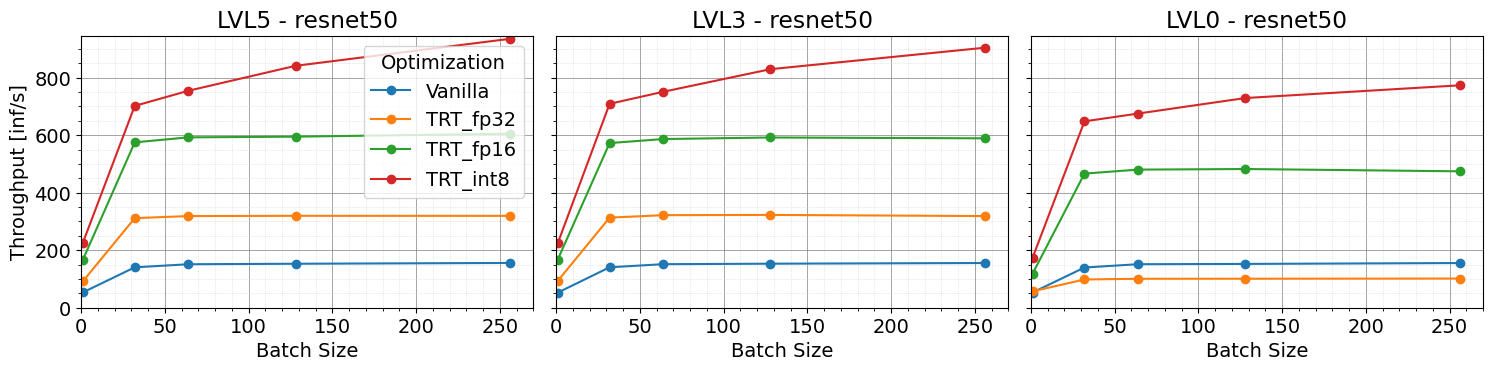

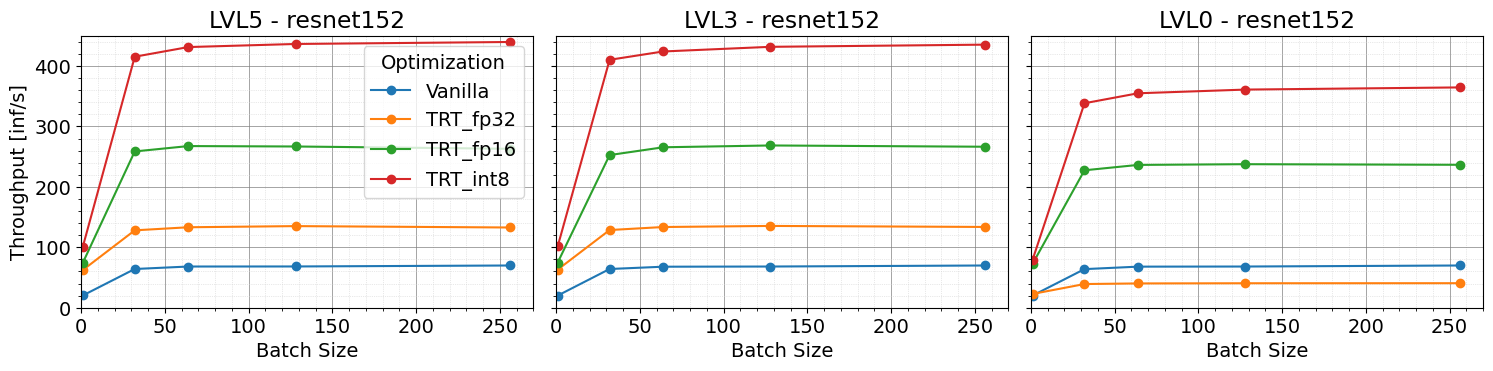

In [59]:
# Ruta del archivo .md
file_path = PATH_TO_MD
with open(file_path, 'r', encoding='utf-8') as file:
    data = file.read()
data_thr = parse_markdown_data_for_throughput(data)
plot_thrs_red_by_power_mode(data_thr)

{'Vanilla': {'LVL5': {'resnet50': (18.8, 35.3), 'resnet152': (49.2, 55.7)}, 'LVL3': {'resnet50': (19.1, 24.8), 'resnet152': (49.8, 56.1)}, 'LVL0': {'resnet50': (18.9, 32.4), 'resnet152': (49.9, 55.6)}}, 'TRT_fp32': {'LVL5': {'resnet50': (10.9, 18.1), 'resnet152': (16.0, 20.3)}, 'LVL3': {'resnet50': (10.8, 17.9), 'resnet152': (15.8, 22.6)}, 'LVL0': {'resnet50': (17.6, 24.9), 'resnet152': (43.9, 50.6)}}, 'TRT_fp16': {'LVL5': {'resnet50': (6.0, 13.9), 'resnet152': (13.4, 19.8)}, 'LVL3': {'resnet50': (6.0, 12.2), 'resnet152': (13.4, 19.3)}, 'LVL0': {'resnet50': (8.5, 14.6), 'resnet152': (13.8, 20.5)}}, 'TRT_int8': {'LVL5': {'resnet50': (4.4, 12.2), 'resnet152': (9.9, 16.7)}, 'LVL3': {'resnet50': (4.5, 10.9), 'resnet152': (9.8, 15.5)}, 'LVL0': {'resnet50': (5.8, 13.6), 'resnet152': (12.6, 19.5)}}}


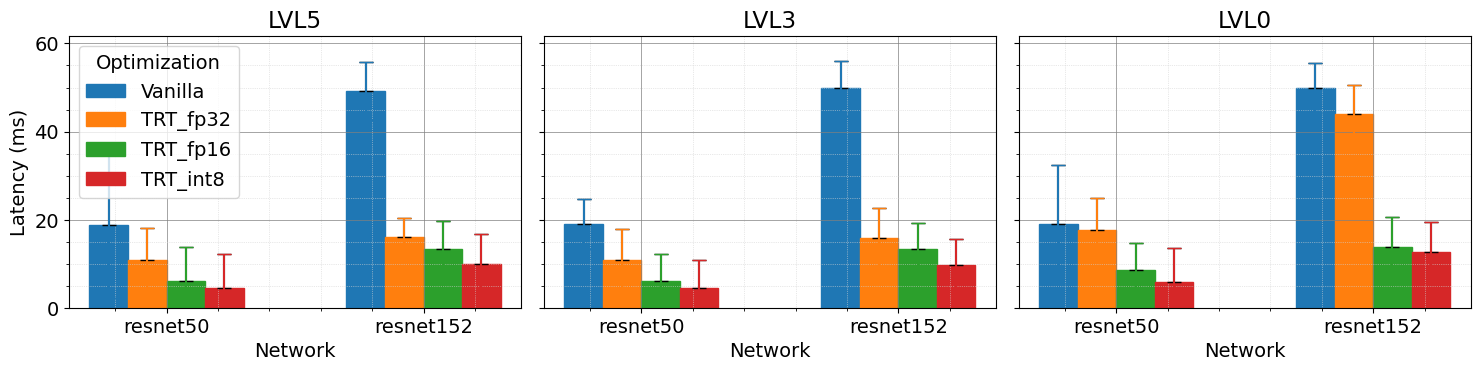

In [60]:
# Ruta del archivo .md
file_path = PATH_TO_MD
# Leer los datos del archivo .md
data = read_data_from_md_for_latency(file_path)
print(data)
plot_model_latency_by_power_mode(data)